In [2]:
#importing all necessary libraries
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import urllib.request
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
import warnings
import gc
import os
import torch.cuda.amp as amp
try:
    from einops import rearrange
except ImportError:
    %pip install /kaggle/input/einops-data-link/einops-0.8.0-py3-none-any.whl
    from einops import rearrange
    
    
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Retina display
%config InlineBackend.figure_format = 'retina'



Processing /kaggle/input/einops-data-link/einops-0.8.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
Device: cuda


In [3]:
# Read in a image from torchvision
given_image = torchvision.io.read_image("/kaggle/input/tree-img/Design project report template.png").to(device)

# Keep only RGB channels
if given_image.shape[0] == 4:
    given_image = given_image[0:3, :, :]  
print(given_image.shape)


torch.Size([3, 2768, 4150])


Text(0.5, 1.0, 'Original Image 400X400')

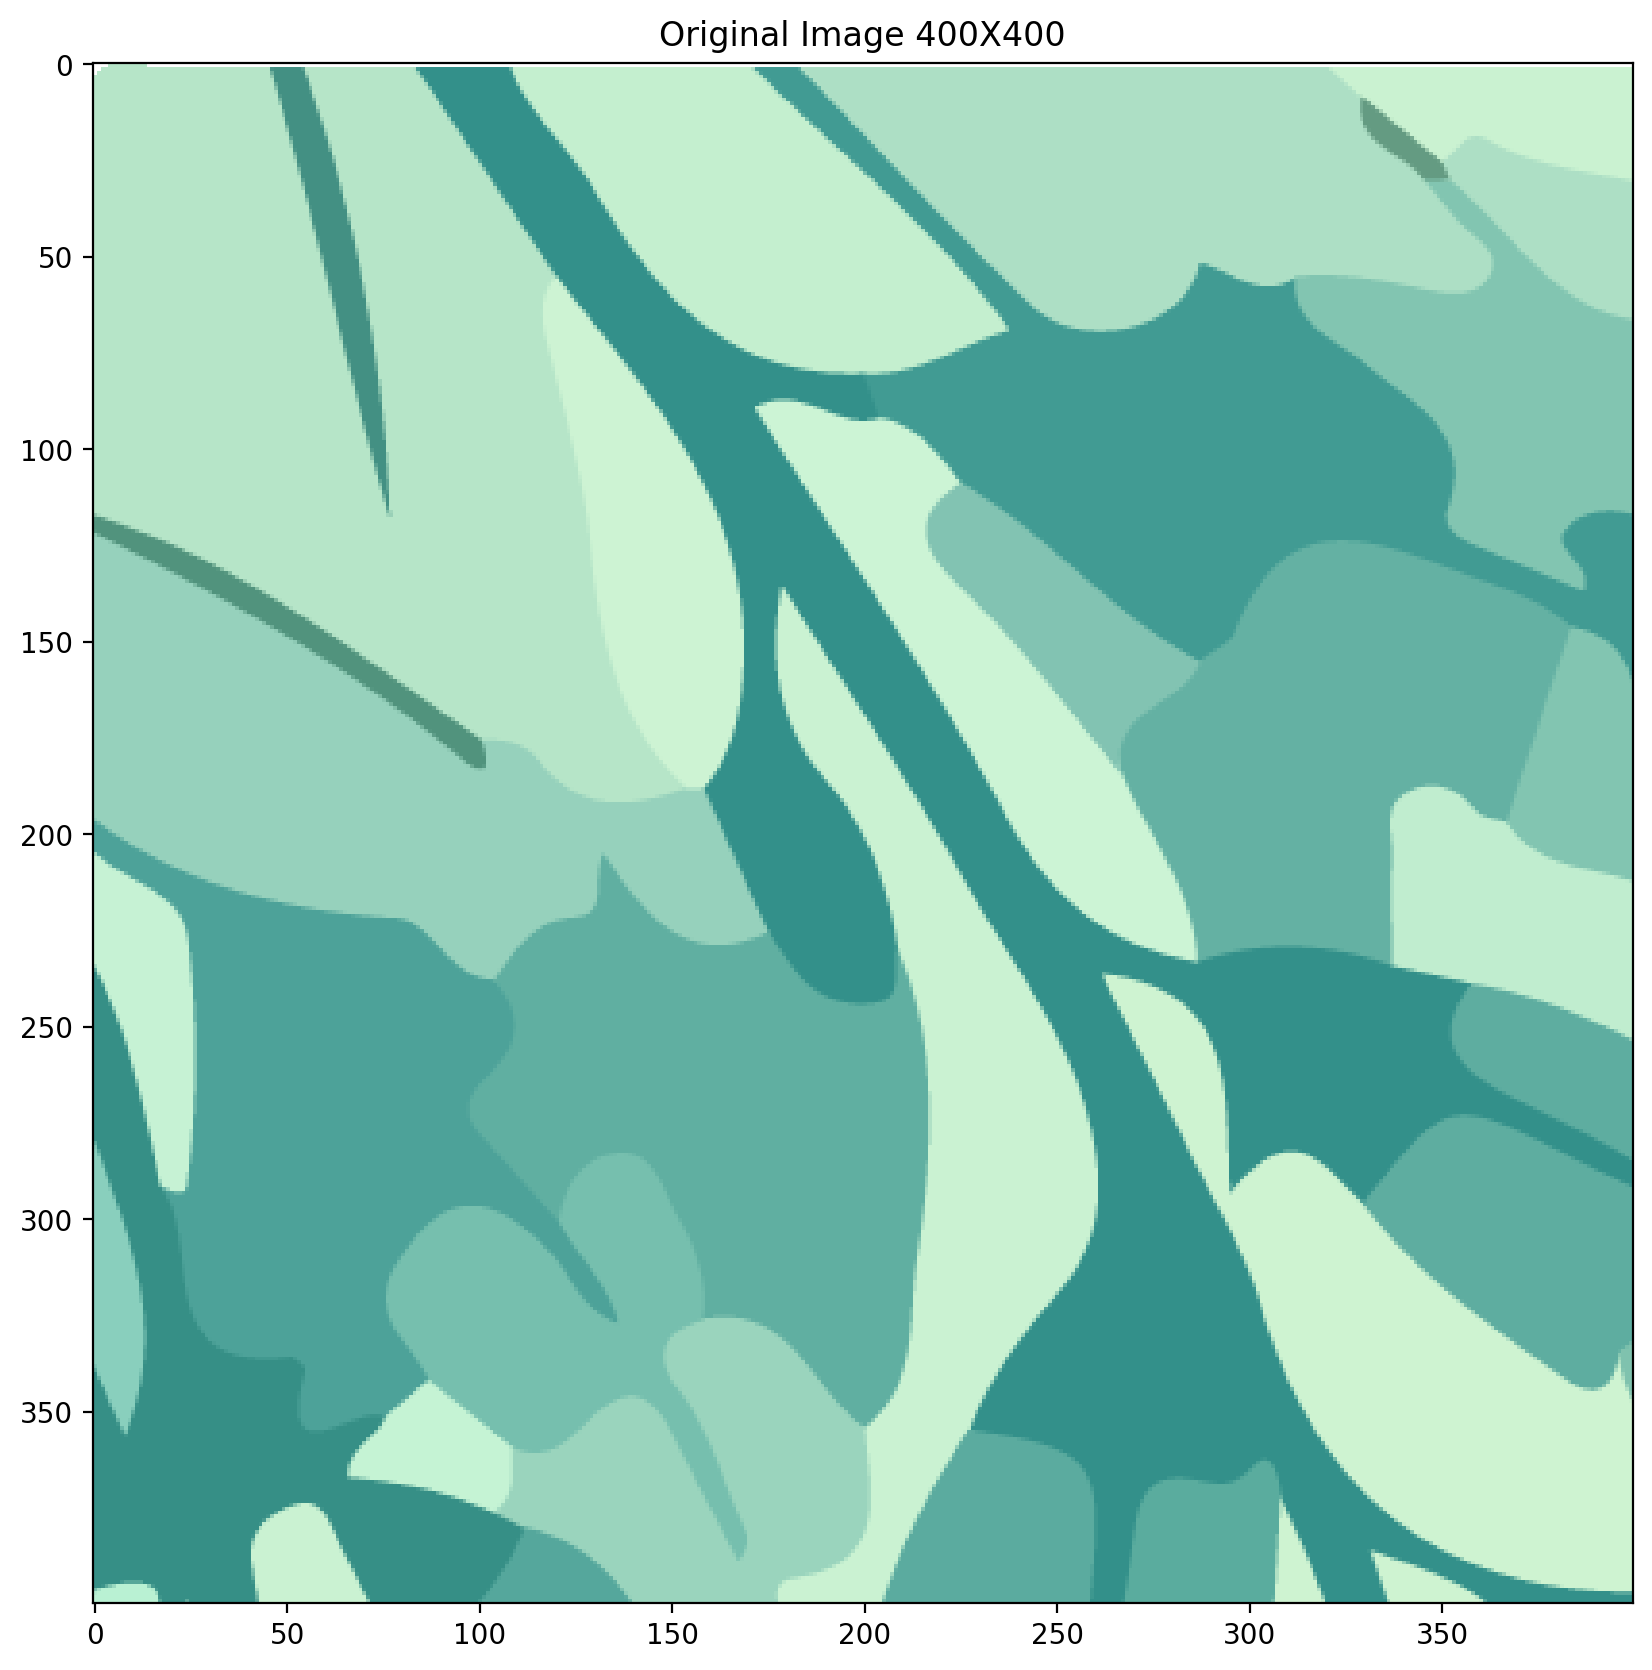

In [4]:
# Crop to 400x400 
img_400x400 = torchvision.transforms.functional.crop(given_image.cpu(), 0, 0, 400, 400).to(device)
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(img_400x400.cpu(), 'c h w -> h w c').numpy())
plt.title("Original Image 400X400")


In [5]:
# Normalize the pixel coordinates to the range (-1, 1)
scaler = preprocessing.MinMaxScaler().fit(img_400x400.cpu().reshape(-1, 1))
scaler

scaled_400x400 = torch.tensor(scaler.transform(img_400x400.cpu().reshape(-1, 1))).reshape(img_400x400.shape).float().to(device)
scaled_400x400 = torch.tensor(scaled_400x400).float().to(device)
print(scaled_400x400.shape)
print(scaled_400x400)


torch.Size([3, 400, 400])
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.6422,  ..., 0.7402, 0.7402, 0.7402],
         [1.0000, 0.6422, 0.6422,  ..., 0.7402, 0.7402, 0.7402],
         ...,
         [0.6176, 0.6569, 0.6569,  ..., 0.1863, 0.1863, 0.1863],
         [0.6569, 0.6569, 0.6569,  ..., 0.0000, 0.0000, 0.0000],
         [0.6569, 0.6569, 0.6569,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.8725,  ..., 0.9363, 0.9363, 0.9363],
         [1.0000, 0.8725, 0.8725,  ..., 0.9363, 0.9363, 0.9363],
         ...,
         [0.9020, 0.9314, 0.9314,  ..., 0.5735, 0.5735, 0.5735],
         [0.9314, 0.9314, 0.9314,  ..., 0.4559, 0.4559, 0.4559],
         [0.9314, 0.9314, 0.9314,  ..., 0.4559, 0.4559, 0.4559]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.7304,  ..., 0.7745, 0.7745, 0.7745],
         [1.0000, 0.7304, 0.7304

torch.Size([3, 200, 200])


Text(0.5, 1.0, 'Low Resolution Image 200X200')

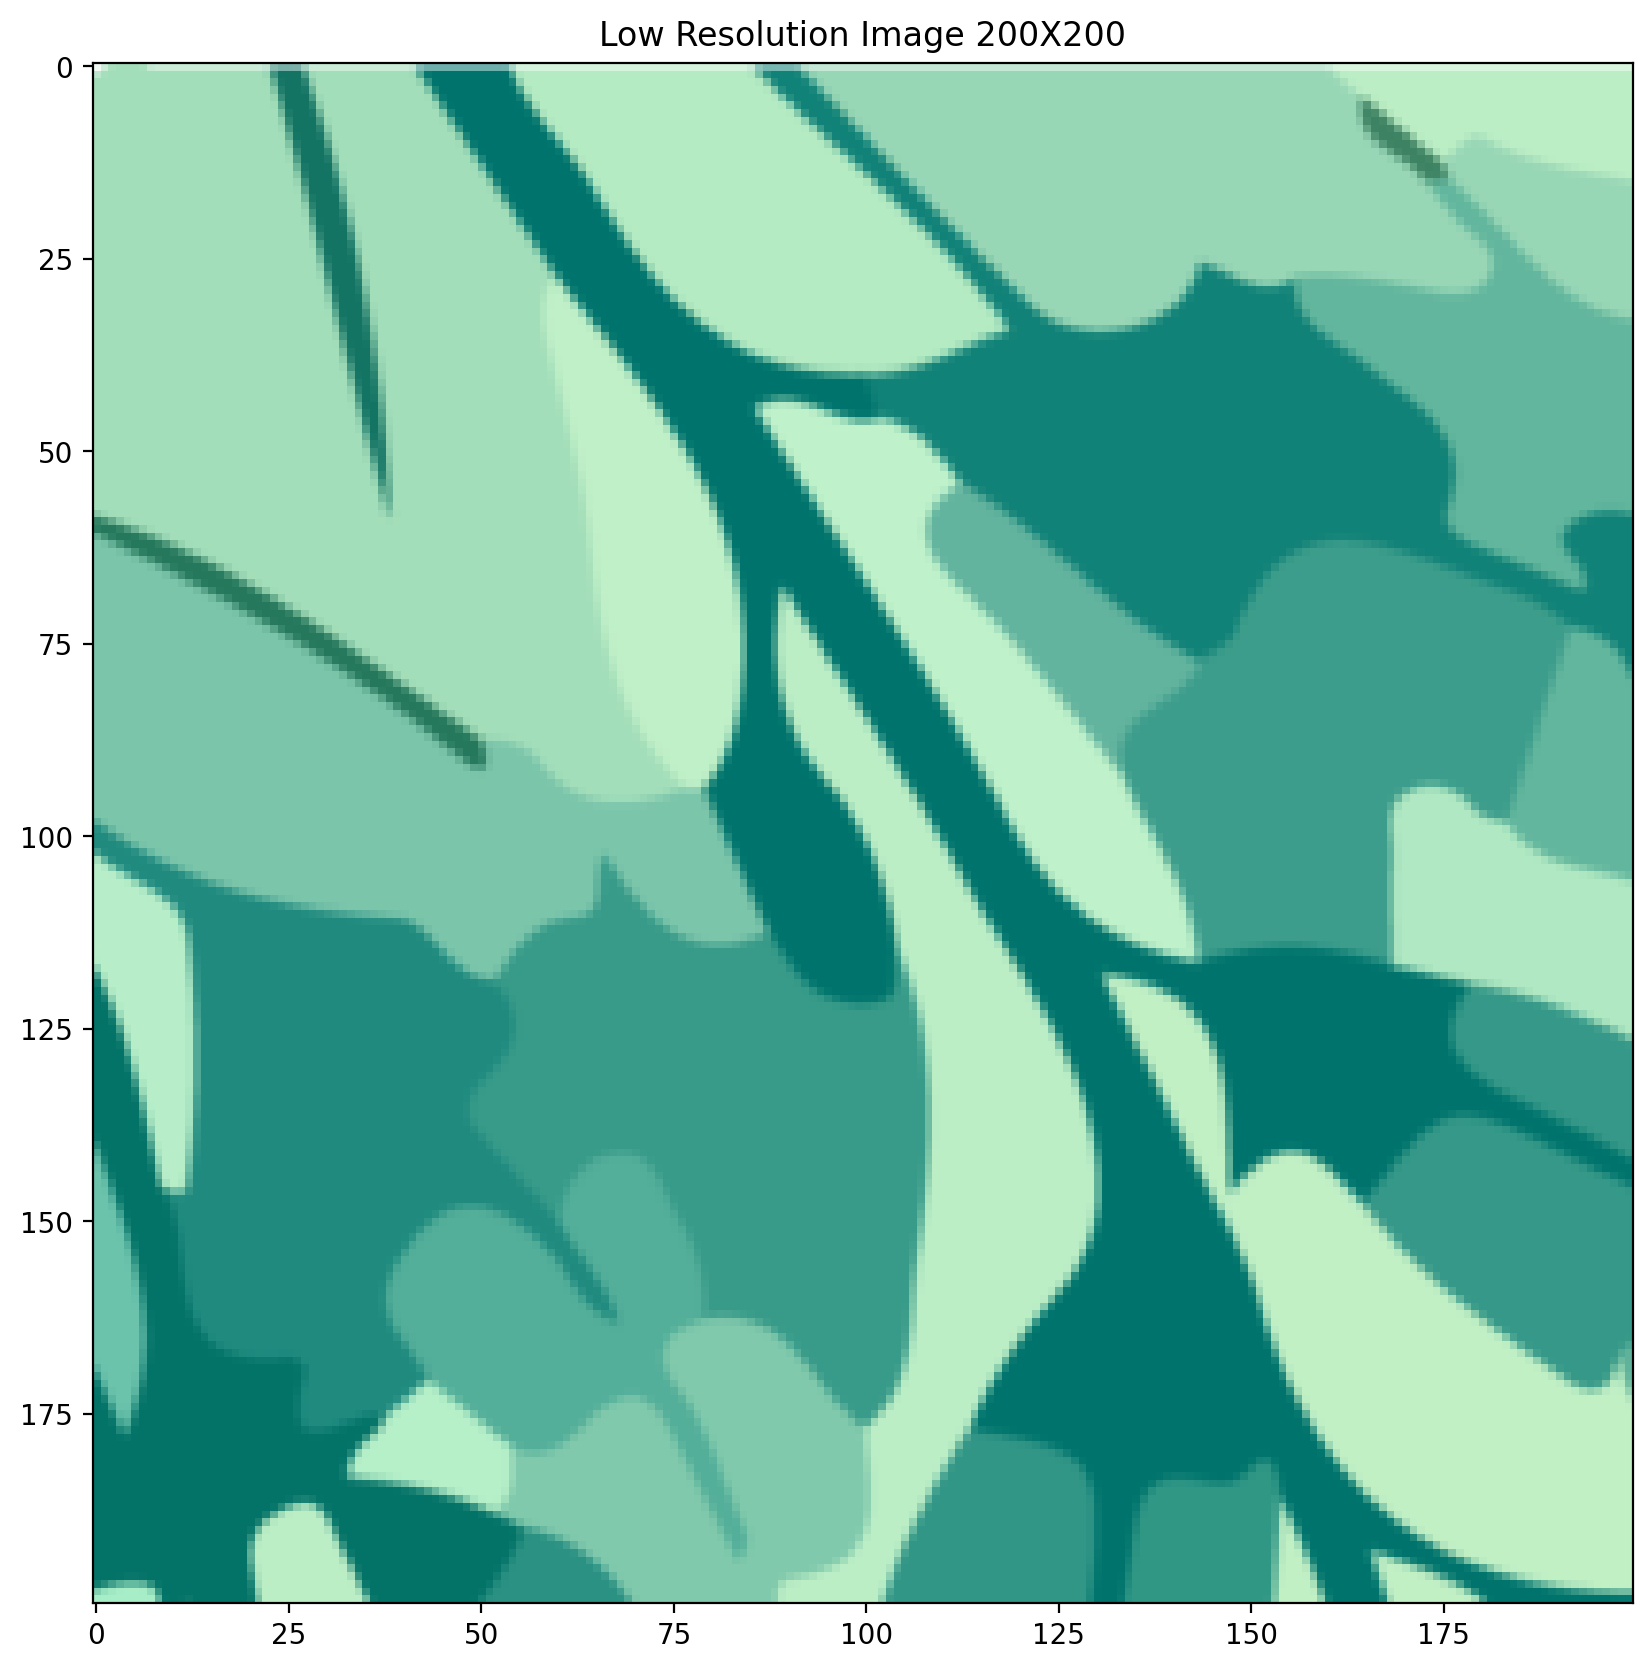

In [6]:
# Transformae to 200x200
resize_transform = transforms.Resize((200, 200))
resize_200x200 = resize_transform(scaled_400x400)
print(resize_200x200.shape)

plt.figure(figsize=(10, 10))
plt.imshow(rearrange(resize_200x200, 'c h w -> h w c').cpu().numpy())
plt.title("Low Resolution Image 200X200")


In [7]:
# Function to create a coordinate map
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    # Generate the grid of pixel coordinates
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    
    # Repeat pixel values and flatten them for the corresponding coordinates
    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)
    Y = rearrange(img, 'c h w -> (h w) c').float().to(device)
    return X, Y


In [8]:
# Define the Linear Model 
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
    

In [9]:

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module    lr: float    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    # Define the loss function (Mean Squared Error) and optimizer (Stochastic Gradient Descent)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scaler = amp.GradScaler()
    
    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        with amp.autocast():
            # Forward pass: compute predicted pixel values
            outputs = net(X)
            
            # Compute the loss
            loss = criterion(outputs, Y)
            
        # Backward pass: compute gradients
        scaler.scale(loss).backward()
        
        # Update the model parameters
        scaler.step(optimizer)
        scaler.update()
        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()


In [10]:
# Function to plot images 
def plot_img(image, X_rff_enhanced, net, scale = 1, return_Output = 0):
    """
    image: torch.Tensor of shape (num_channels, height, width)
    X_rff_enhanced: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module    scale: int    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)
    """
    num_channels, height, width = image.shape

    height *= scale
    width *= scale

    # Predict the enhanced image using the trained model
    with torch.no_grad():
        outputs = net(X_rff_enhanced)
        enhanced_img = outputs.reshape(num_channels, height, width).to(device)
        
    # Create a side-by-side plot of the original and enhanced images
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height//scale}x{width//scale})')
    ax0.imshow(rearrange(image, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Enhanced Image ({height}x{width})')
    ax1.imshow(enhanced_img.reshape(height,width,num_channels).cpu().detach().numpy())

    fig.suptitle('Low Resolution vs Enhanced Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Return the enhanced image tensor
    if(return_Output == 1):
        return enhanced_img


In [11]:
# Function to predict the image
def predict_img(image, num_features, sigma, lr, epochs, device = 'cpu'):
    """
    image: torch.Tensor of shape (num_channels, height, width)
    num_features: int    sigma: float    lr: float    epochs: int    device: str
    """
    # Create a coordinate map for the input (low-resolution) image
    X, Y = create_coordinate_map(image)
    X = X.to(device)
    Y = Y.to(device)

    # Normalize the pixel coordinates to the range (-1, 1)
    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)

    # Compute the RFF features for the scaled coordinates
    rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
    X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)

    # Train the linear model using the RFF features and pixel values
    net = LinearModel(X_rff.shape[1],image.shape[0]).to(device)
    train(net, lr, X_rff, Y, epochs)

    # Free memory by deleting unnecessary variables
    del X_rff, X, Y, scaled_X, scaler
    gc.collect()

    # Create a coordinate map for the high-resolution image
    Xprime, Yprime = create_coordinate_map(image,scale=2)

    # Normalize the new high-resolution pixel coordinates
    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(Xprime.cpu())
    scaled_Xprime = torch.tensor(scaler.transform(Xprime.cpu())).float().to(device)

    # Plot the low-resolution input image and the predicted high-resolution image
    X_rff = torch.tensor(rff.transform(scaled_Xprime.cpu().numpy())).float().to(device)
    print("\nComparison Between Low Resolution Image and Enhanced Image:")
    Output = plot_img(image, X_rff, net, scale = 2, return_Output = 1)
    
    # Free memory by deleting unnecessary variables
    del net, X_rff, Xprime, Yprime, scaled_Xprime, scaler
    gc.collect()
    
    # Return predicted image
    return Output

Epoch 0 loss: 0.386569
Epoch 500 loss: 0.000475
Epoch 1000 loss: 0.000421
Epoch 1500 loss: 0.000405
Epoch 2000 loss: 0.000397
Epoch 2500 loss: 0.000393
Epoch 3000 loss: 0.000389

Comparison Between Low Resolution Image and Enhanced Image:


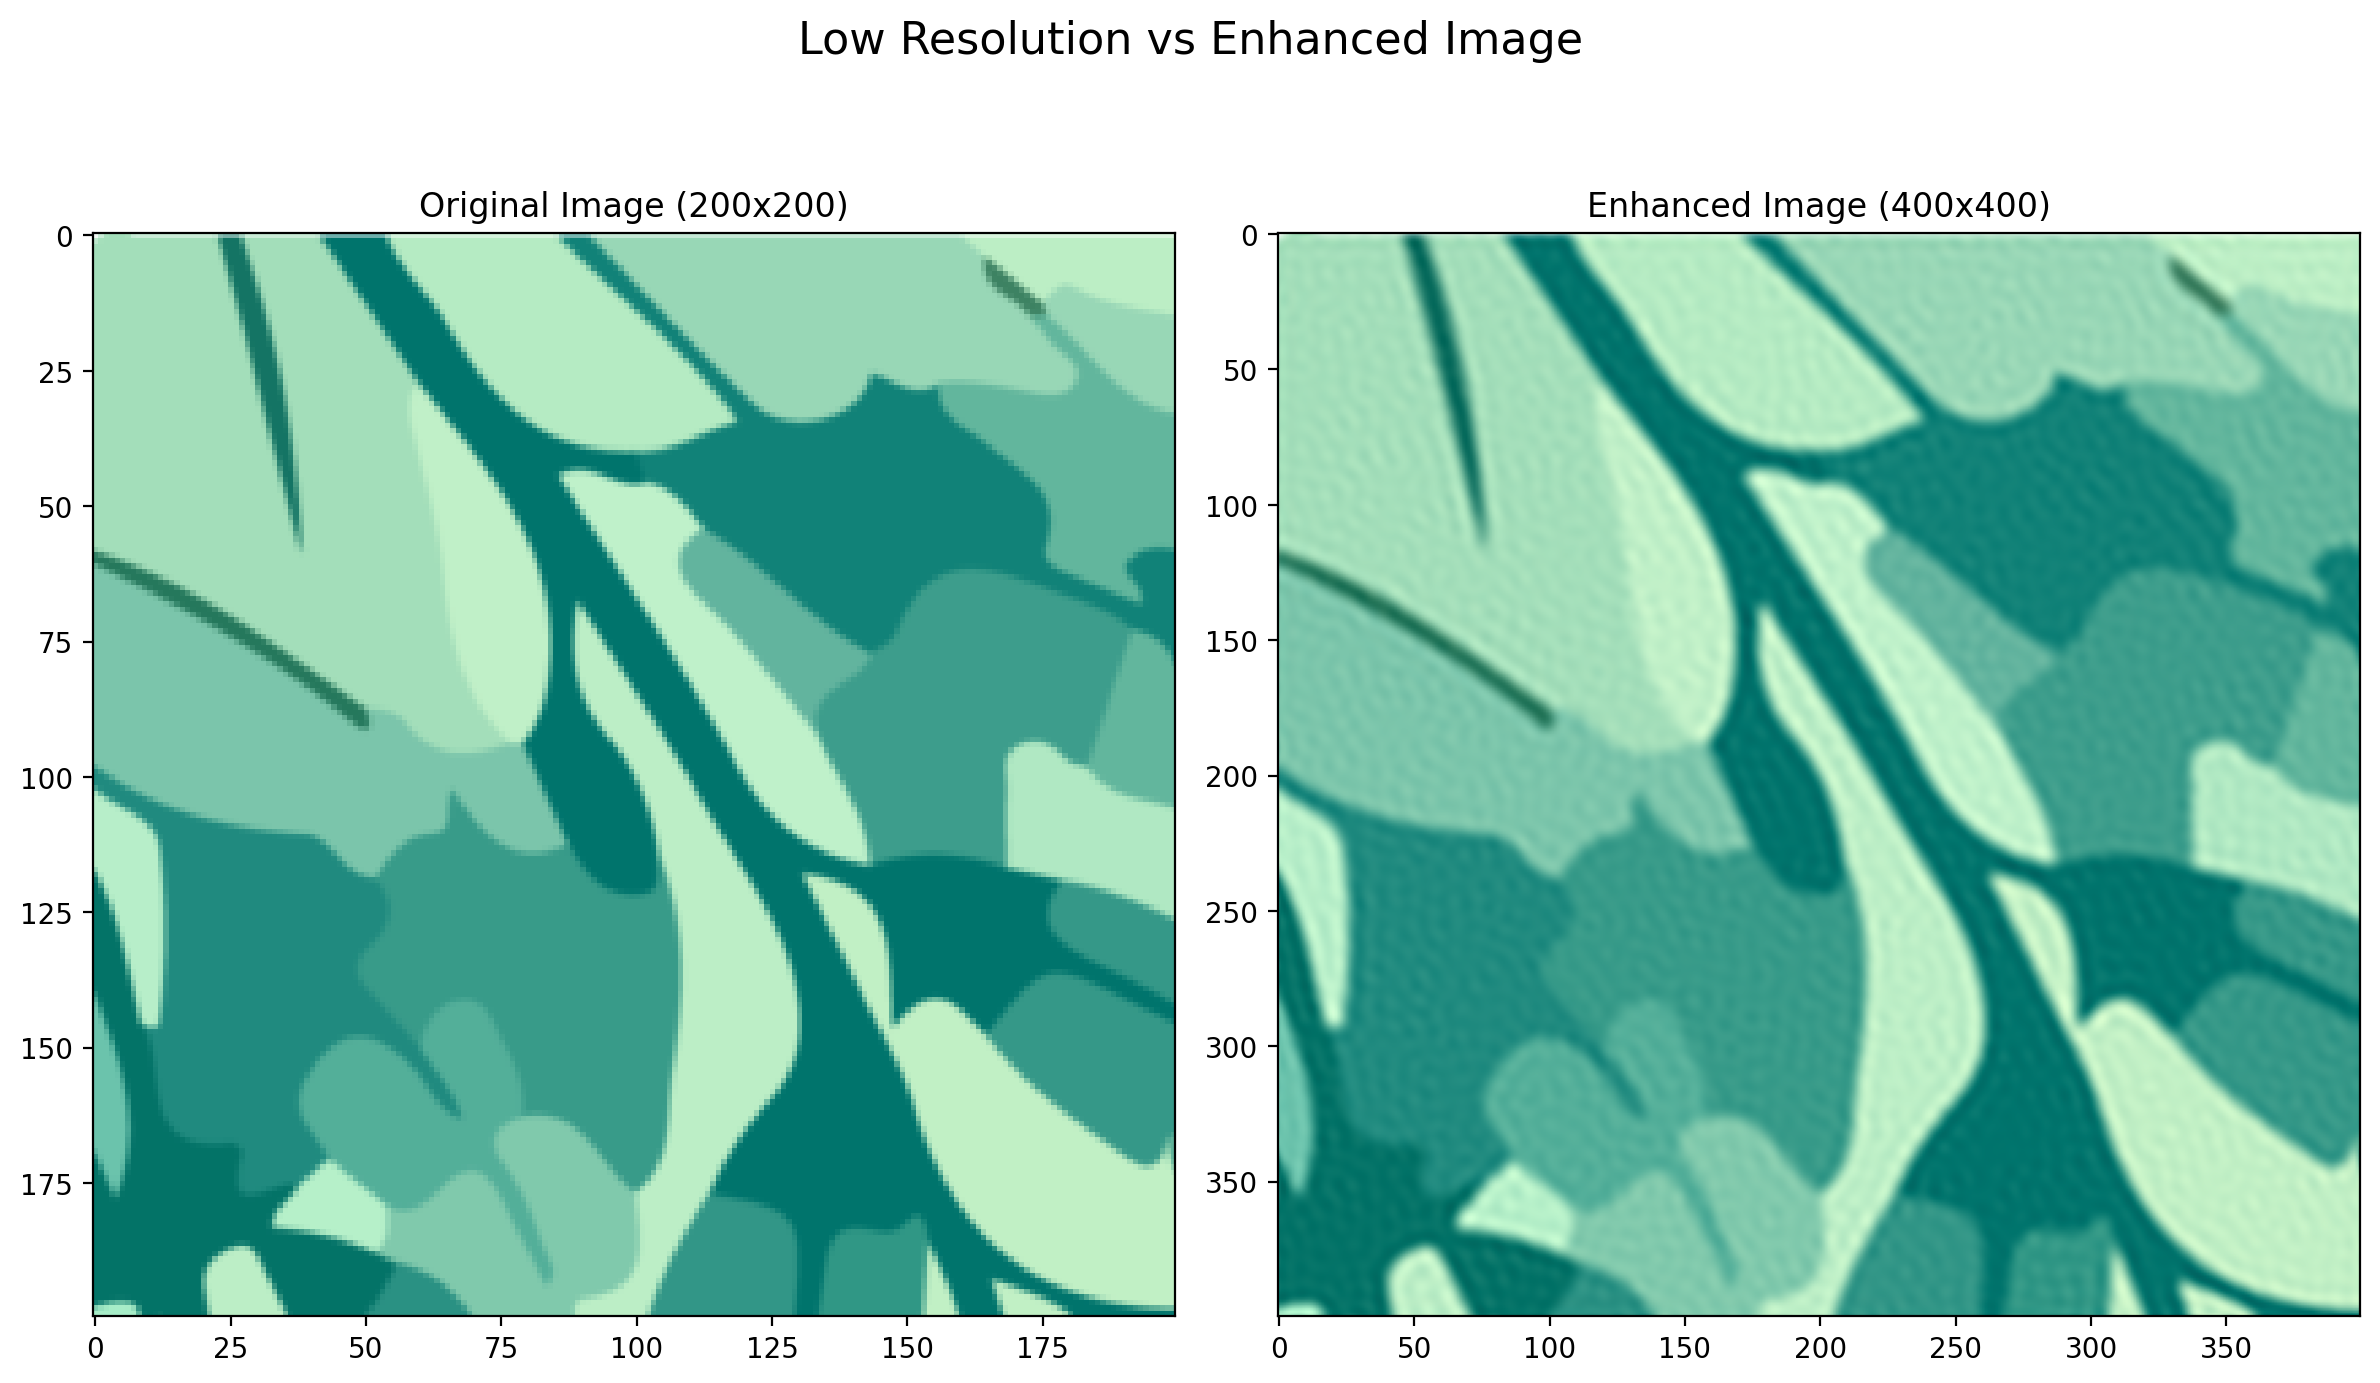

In [98]:
output_image = predict_img(resize_200x200,20000,0.015, 0.005, 3000, device = 'cpu')

Original vs Enhanced Image (Subjective Analysis):
* The original image (400x400) and the enhanced image (predicted via super-resolution) are displayed side by side.
* The enhanced image attempts to restore finer details and sharpen the edges compared to the low-resolution version.
* While the enhancement is visually noticeable, some subtle textures may still differ from the original due to the limitations of the super-resolution technique, leading to potential artifacts or smoothened areas.

In [20]:
# Convert images to numpy arrays
original_np = img_400x400.cpu().numpy()/255
enhanced_np = output_image.cpu().numpy()

# Ensure the images are of the same shape
assert original_np.shape == enhanced_np.shape

# Reshape the image to match dimensions
original_np = original_np.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
enhanced_np = enhanced_np.transpose(1, 2, 0)

# Compute RMSE (Root Mean Square Error)
rmse_val = np.sqrt(np.mean((original_np - enhanced_np) ** 2))
print(f"RMSE: {rmse_val:.4f}")

# Compute PSNR (Peak Signal-to-Noise Ratio)
psnr_val = psnr(original_np, enhanced_np)
print(f"PSNR: {psnr_val:.4f}")

RMSE: 0.3255
PSNR: 9.7498
